In [2]:
### run my startup script
exec(open("../src/functions/fun_loadStartup.py").read())
### load my functions
exec(open("../src/functions/fun_loadMyFunctions.py").read())

%config InlineBackend.figure_format='png'

### Load grid
grdFile = '../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc'
grid = loadRomsGrid(grdFile)


loaded my modules
loaded my own functions
loading ROMS grid from ../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc


### Load functions

In [3]:
### function to load overlapping OSSE data
def loadOSSE(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = glob.glob(hisFilePath+prefix+filestring)

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

#     for files in filelist: 
#         print(files)
    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def dropDuplicateTimes(inputData):
    _, index = np.unique(inputData['ocean_time'], return_index=True)
    out = inputData.isel(ocean_time=index)
    return out

def calc_rmseSpatial(input1,input2,etaRange,xiRange):
    err2 = (input1-input2)**2
    err=err2**(1/2)
    output = indexMeanMetric(err,etaRange,xiRange)
    return err,output

# define function for calculating spatial mean
def indexMeanMetric(input,etaRange,xiRange):
    ''' iRange and jRange are converted to slices, so they are the start/end values of the range '''
    output = input.isel(eta_rho=slice(etaRange[0],etaRange[1]), xi_rho=slice(xiRange[0],xiRange[1])).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
    return output

def simple_TimeSeries(inputDataX, inputDataY, plt_kwargs={}, ax=None):
    #Plotting
    if ax is None:
        ax = plt.gca()   
    hOut = ax.plot(inputDataX, inputDataY, **plt_kwargs)
    ax.grid(color='black', alpha=0.2, linestyle='--')
    return(hOut)

def plot_spatialMapSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def plot_spatialMapGSSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def calc_boxSpatial(grid,etaRange,xiRange):
    pt00lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    pt00la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    boxLo = np.array([pt00lo, pt01lo, pt11lo, pt10lo, pt00lo])
    boxLa = np.array([pt00la, pt01la, pt11la, pt10la, pt00la])
    return boxLo,boxLa

def datestring_to_serial_day(datestring,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import pandas as pd
    import datetime
    serial_day_timedelta = pd.to_datetime(datestring) - datetime.datetime(epochY,epochm,epochd,epochH,epochM)
    corrected_serial_day_number = serial_day_timedelta.days + serial_day_timedelta.seconds/86400
    return corrected_serial_day_number


def serial_day_to_datestring(day,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import datetime
    corrected_date = datetime.datetime(epochY,epochm,epochd,epochH,epochM) + datetime.timedelta(day)
    return corrected_date.strftime("%Y-%m-%d %H:%M")  

# Check obs files that are sent to truth run


In [4]:
### Set file names
runningLocation = 'local'
if  runningLocation== 'local':
    obsVerifFilePath='/Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif_XBT/' # outputted obs files from ROMS_ObsPrep, that are supplied to first truth run
    modTruthFilePath='/Users/dave/Documents/dave/Projects/ROMS_ObsPrep/cache/obs_truth_output_XBT/' # output mod files from truth run. 
    obsFinalFilePath='/Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_final_SSH_SST_XBT/' #the 'final' obs files: Verification obs, + NLmodel values from modTruth.

elif runningLocation == 'gdata':
    hisFilePath='/g/data/fu5/deg581/EAC_2yr_OSSE_/output/'
    truthFilePath='/g/data/fu5/deg581/EAC_2yr_ObsVerification_HighRes/output/' # Truth file settings

prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'
prefixTruth='outer_his_'
prefixObs='eac_obs_'
prefixMod='eac_mod_'
prefixPert='outer_his_'

outFigurePath='../cache/out/'

In [5]:
timeRange = [8001, 8033]
assimPeriod = 5
assimOverlap = 1

pRangeSSH=405
pRangeSST=340
pRangeXBT=939

## 
datelist = np.array(range(timeRange[0],timeRange[1],4))

In [6]:


fig = plt.figure(figsize=(20,5))
ax = plt.axes()

for dates in datelist:

    filenameObs=obsVerifFilePath+prefixObs+''+str(dates)+'.nc'
    print('loading ',filenameObs)
    obs=xr.open_dataset(filenameObs).load()
    vobs=obs.obs_value.where(obs.obs_provenance==pRangeSSH)
    lo=obs.obs_lon.where(obs.obs_provenance==pRangeSSH)
    la=obs.obs_lat.where(obs.obs_provenance==pRangeSSH)
    t=obs.obs_time.where(obs.obs_provenance==pRangeSSH)

    if dates!=datelist[-1]:
        ax.plot(t, vobs, "C0", marker='.', markersize=1, linestyle='None',zorder=1,label='_nolegend_')
    else:
        ax.plot(t, vobs, "C0", marker='.', markersize=1, linestyle='None',zorder=1,label='obs_value for '+str(pRangeSSH))


    vobs=obs.obs_value.where(obs.obs_provenance==pRangeSST)
    lo=obs.obs_lon.where(obs.obs_provenance==pRangeSST)
    la=obs.obs_lat.where(obs.obs_provenance==pRangeSST)
    t=obs.obs_time.where(obs.obs_provenance==pRangeSST)

    if dates!=datelist[-1]:
        ax.plot(t, vobs, "C1", marker='.', markersize=1, linestyle='None',zorder=1,label='_nolegend_')
    else:
        ax.plot(t, vobs, "C1", marker='.', markersize=1, linestyle='None',zorder=1,label='obs_value for '+str(pRangeSST))
    
    vobs=obs.obs_value.where(obs.obs_provenance==pRangeXBT)
    lo=obs.obs_lon.where(obs.obs_provenance==pRangeXBT)
    la=obs.obs_lat.where(obs.obs_provenance==pRangeXBT)
    t=obs.obs_time.where(obs.obs_provenance==pRangeXBT)

    if dates!=datelist[-1]:
        ax.plot(t, vobs, "C2", marker='.', markersize=1, linestyle='None',zorder=1,label='_nolegend_')
    else:
        ax.plot(t, vobs, "C2", marker='.', markersize=1, linestyle='None',zorder=1,label='obs_value for '+str(pRangeXBT))

#ax.plot(t, vobs, "C0", marker='.', markersize=10, linestyle='None',label='obs_value for '+str(pRangeSSH),zorder=1)
ax.legend()



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif_XBT/eac_obs_8001.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif_XBT/eac_obs_8005.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif_XBT/eac_obs_8009.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif_XBT/eac_obs_8013.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif_XBT/eac_obs_8017.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif_XBT/eac_obs_8021.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif_XBT/eac_obs_8025.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif_XBT/eac_obs_8029.nc


In [7]:

pRange=340
print('obs_depth',obs.obs_depth.where(obs.obs_provenance==pRange, drop=True).values, obs.obs_depth.where(obs.obs_provenance==pRange, drop=True).values.mean())
print('obs_Zgrid',obs.obs_Zgrid.where(obs.obs_provenance==pRange, drop=True).values, obs.obs_Zgrid.where(obs.obs_provenance==pRange, drop=True).values.mean())
print('obs_value',obs.obs_value.where(obs.obs_provenance==pRange, drop=True).values, obs.obs_value.where(obs.obs_provenance==pRange, drop=True).values.mean())
print('obs_type',obs.obs_type.where(obs.obs_provenance==pRange, drop=True).values, obs.obs_type.where(obs.obs_provenance==pRange, drop=True).values.mean())

pRange=405
print('obs_depth',obs.obs_depth.where(obs.obs_provenance==pRange, drop=True).values, obs.obs_depth.where(obs.obs_provenance==pRange, drop=True).values.mean())
print('obs_Zgrid',obs.obs_Zgrid.where(obs.obs_provenance==pRange, drop=True).values, obs.obs_Zgrid.where(obs.obs_provenance==pRange, drop=True).values.mean())
print('obs_value',obs.obs_value.where(obs.obs_provenance==pRange, drop=True).values, obs.obs_value.where(obs.obs_provenance==pRange, drop=True).values.mean())
print('obs_type',obs.obs_type.where(obs.obs_provenance==pRange, drop=True).values, obs.obs_type.where(obs.obs_provenance==pRange, drop=True).values.mean())

pRange=939
print('obs_depth',obs.obs_depth.where(obs.obs_provenance==pRange, drop=True).values, obs.obs_depth.where(obs.obs_provenance==pRange, drop=True).values.mean())
print('obs_Zgrid',obs.obs_Zgrid.where(obs.obs_provenance==pRange, drop=True).values, obs.obs_Zgrid.where(obs.obs_provenance==pRange, drop=True).values.mean())
print('obs_value',obs.obs_value.where(obs.obs_provenance==pRange, drop=True).values, obs.obs_value.where(obs.obs_provenance==pRange, drop=True).values.mean())
print('obs_type',  obs.obs_type.where(obs.obs_provenance==pRange,  drop=True).values, obs.obs_type.where(obs.obs_provenance==pRange, drop=True).values.mean())

obs_depth [] nan
obs_Zgrid [] nan
obs_value [] nan
obs_type [] nan
obs_depth [] nan
obs_Zgrid [] nan
obs_value [] nan
obs_type [] nan
obs_depth [26.9096622  22.29417541 18.89615312 ...  6.51158633  5.51739201
  4.69338983] 17.37614102036143
obs_Zgrid [26.9096622  22.29417541 18.89615312 ...  6.51158633  5.51739201
  4.69338983] 17.37614102036143
obs_value [25. 25. 25. ... 25. 25. 25.] 25.0
obs_type [6. 6. 6. ... 6. 6. 6.] 6.0


<ipython-input-7-bfc5e9f42f65>:2: RuntimeWarning: Mean of empty slice.
  print('obs_depth',obs.obs_depth.where(obs.obs_provenance==pRange, drop=True).values, obs.obs_depth.where(obs.obs_provenance==pRange, drop=True).values.mean())
/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-7-bfc5e9f42f65>:3: RuntimeWarning: Mean of empty slice.
  print('obs_Zgrid',obs.obs_Zgrid.where(obs.obs_provenance==pRange, drop=True).values, obs.obs_Zgrid.where(obs.obs_provenance==pRange, drop=True).values.mean())
/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-7-bfc5e9f42f65>:4: RuntimeWarning: Mean of empty slice.
  print('obs_value',obs.obs_value.where(obs.obs_provenance==pRange, drop=True).values, obs.

In [8]:
pRange=939

for day in datelist: 
    obsFileName = ''+str(day)+'.nc'
    obsPath = obsVerifFilePath+prefixObs+obsFileName

    print('opening '+obsFileName)
    obs = xr.open_dataset(obsPath)

    tRange=np.arange(day,day+assimPeriod,1)

    fig, axes = plt.subplots(ncols=assimPeriod, figsize=(16, 3), subplot_kw={'projection': ccrs.PlateCarree()})
    for ax, tRangeStart in zip(axes, tRange):
        print(type(ax), tRangeStart)
        v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>=tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>=tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>=tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>=tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        sc = ax.scatter(x=lo,y=la,c=v,marker='.')
        ax.text(.1,.95,str(tRangeStart),horizontalalignment='center',transform=ax.transAxes)
        sc.set_clim([0,30])
    # fig.colorbar(sc, ax=axes.ravel().tolist(),orientation='horizontal')
    plt.tight_layout()
    fig.colorbar(sc)

opening 8001.nc


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8001
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8002
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8003
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8004
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005
opening 8005.nc


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8006
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8007
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8008
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8009
opening 8009.nc


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8009
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8010
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8011
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8012
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8013
opening 8013.nc


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8013
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8014
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8015
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8016
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8017
opening 8017.nc


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8017
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8018
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8019
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8020
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8021
opening 8021.nc


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8021
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8022
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8023
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8024
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8025
opening 8025.nc


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8025
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8026
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8027
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8028
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8029
opening 8029.nc


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8029
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8030
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8031
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8032
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8033


In [9]:
pRange=939

for day in np.arange(dStart,dEnd,assimPeriod-assimOverlap): 
    obsFileName = ''+str(day)+'.nc'
    obsPath = obsVerifFilePath+prefixObs+obsFileName
    print('opening '+obsFileName)
    obs = xr.open_dataset(obsPath)

    tRangeStart=np.arange(day,day+assimPeriod,1/24)
    tRangeEnd=np.arange(day+1/24,day+assimPeriod+1/24,1/24)

    fig = plt.figure(figsize=(13,24))
    iSz,jSz = (16,6)
    gs = fig.add_gridspec(iSz, jSz)

    for ax, tStart, tEnd in zip(range(iSz*jSz), tRangeStart, tRangeEnd):
        ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
        print(type(ax), round((tStart-tRangeStart[0])*24), round((tEnd-tRangeStart[0])*24))
        v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>tStart) & (obs.obs_time<tEnd), drop=True)
        lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>tStart) & (obs.obs_time<tEnd), drop=True)
        la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>tStart) & (obs.obs_time<tEnd), drop=True)
        t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>tStart) & (obs.obs_time<tEnd), drop=True)
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance)#, vmin=-1, vmax=1, zorder=10)
        ax.text(.3,.95,str(round((tEnd-tRangeStart[0])*24)),horizontalalignment='center',transform=ax.transAxes)
        ax.text(.1,.95,str(day),horizontalalignment='center',transform=ax.transAxes)
        sc.set_clim([-1,1])
        cb = fig.colorbar(sc)
    # fig.colorbar(sc, ax=axes.ravel().tolist(),orientation='horizontal')
    plt.tight_layout()
    # plt.savefig('temp.png')


NameError: name 'dStart' is not defined

       opening 8001.nc
8001
<xarray.DataArray 'obs_value' ()>
array(25.)
8002
<xarray.DataArray 'obs_value' ()>
array(25.)
8003
<xarray.DataArray 'obs_value' ()>
array(25.)
8004
<xarray.DataArray 'obs_value' ()>
array(25.)
8005
<xarray.DataArray 'obs_value' ()>
array(nan)
       opening 8005.nc
8005
<xarray.DataArray 'obs_value' ()>
array(nan)
8006
<xarray.DataArray 'obs_value' ()>
array(nan)
8007
<xarray.DataArray 'obs_value' ()>
array(nan)
8008
<xarray.DataArray 'obs_value' ()>
array(25.)
8009
<xarray.DataArray 'obs_value' ()>
array(nan)
       opening 8009.nc
8009
<xarray.DataArray 'obs_value' ()>
array(25.)
8010
<xarray.DataArray 'obs_value' ()>
array(25.)
8011
<xarray.DataArray 'obs_value' ()>
array(25.)
8012
<xarray.DataArray 'obs_value' ()>
array(nan)
8013
<xarray.DataArray 'obs_value' ()>
array(nan)
       opening 8013.nc
8013
<xarray.DataArray 'obs_value' ()>
array(nan)
8014
<xarray.DataArray 'obs_value' ()>
array(nan)
8015
<xarray.DataArray 'obs_value' ()>
array(25.)
8016
<xa

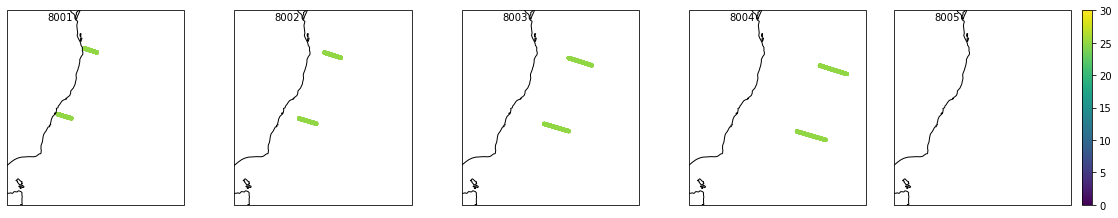

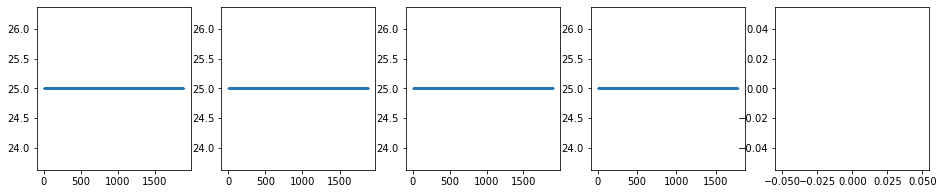

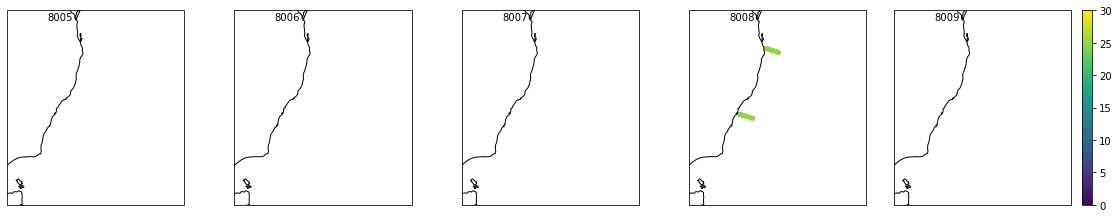

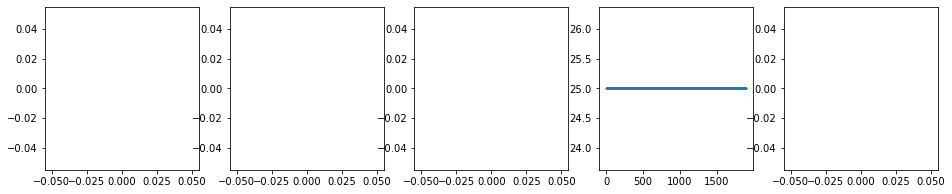

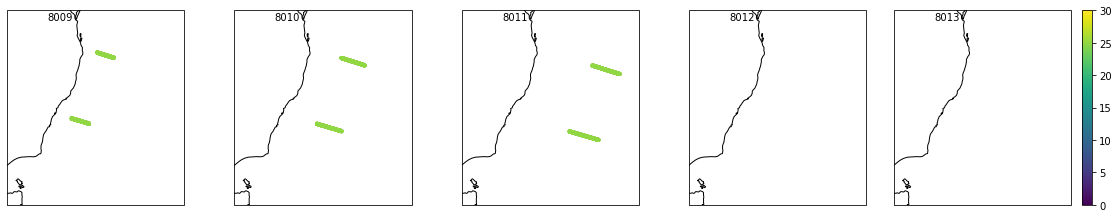

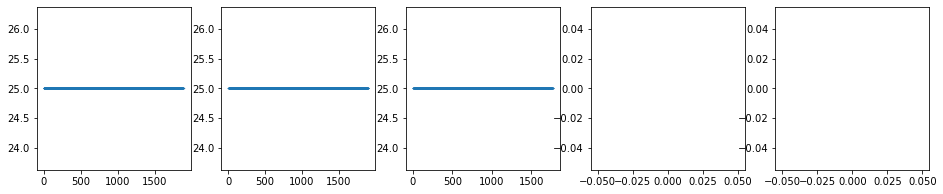

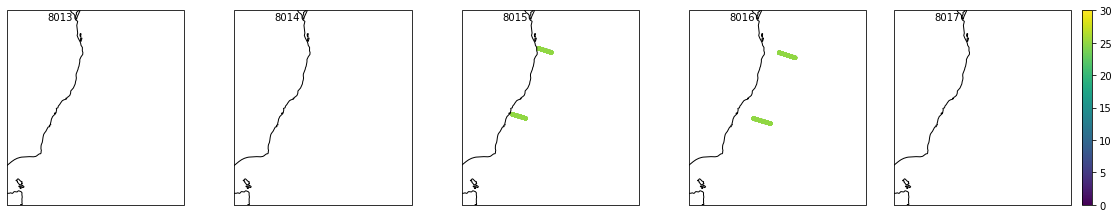

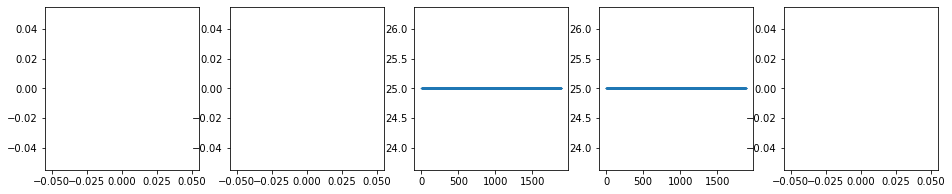

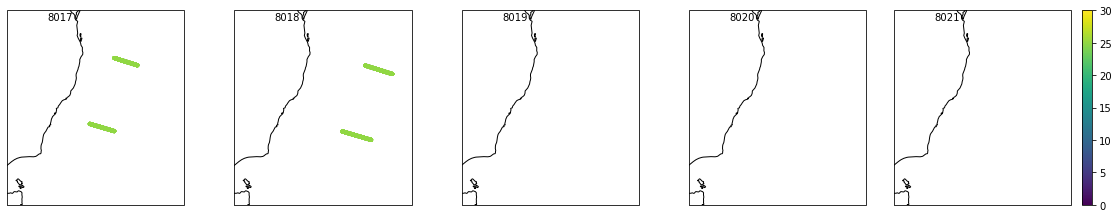

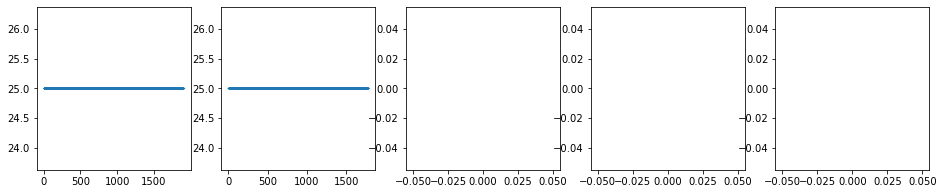

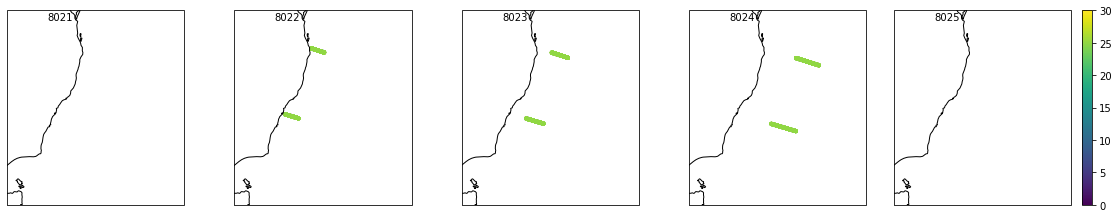

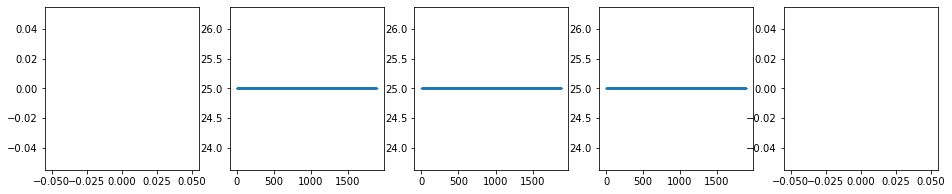

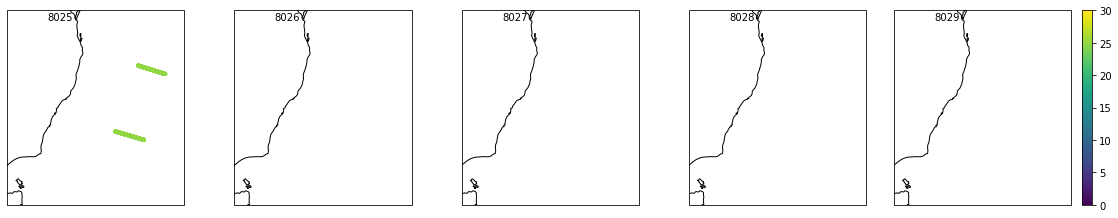

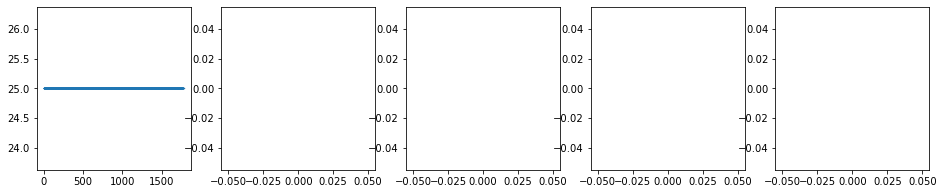

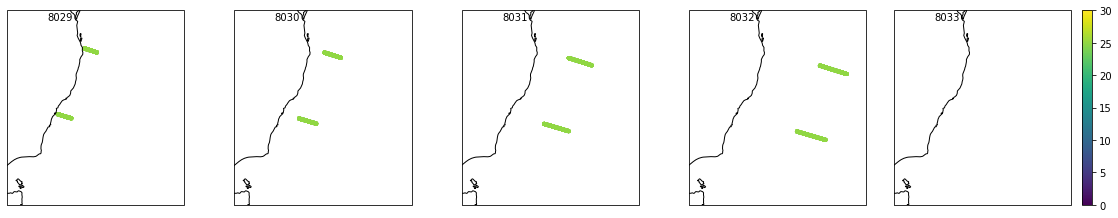

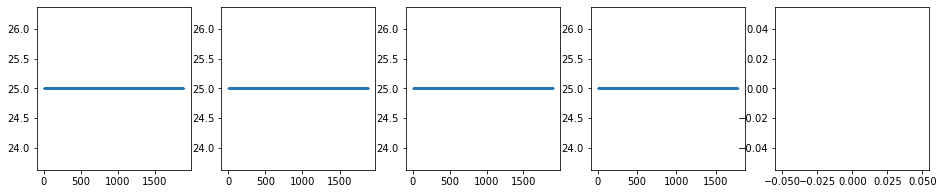

In [ ]:



datelist = np.array(range(timeRange[0],timeRange[1],4))

pRange=939

for day in datelist: 
    obsFileName = ''+str(day)+'.nc'
    obsPath = obsVerifFilePath+prefixObs+obsFileName
    print('       opening '+obsFileName)
    obs = xr.open_dataset(obsPath)

    tRange=np.arange(day,day+assimPeriod,1)
    fig, axes = plt.subplots(ncols=assimPeriod, figsize=(16, 3), subplot_kw={'projection': ccrs.PlateCarree()})
    for ax, tRangeStart in zip(axes, tRange):
        v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='none')
        sc = ax.scatter(x=lo,y=la,c=v,marker='.')
        ax.text(.3,.95,str(tRangeStart),horizontalalignment='center',transform=ax.transAxes)
        sc.set_clim([0,30])
    plt.tight_layout()
    fig.colorbar(sc)

    fig, axes = plt.subplots(ncols=assimPeriod, figsize=(16, 3))
    for ax, tRangeStart in zip(axes, tRange):
        print(tRangeStart)
        v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        ax.plot(v, marker='.', markersize=1, linestyle='None')
        print(v.mean())


loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif_XBT/eac_obs_8001.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif_XBT/eac_obs_8005.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif_XBT/eac_obs_8009.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif_XBT/eac_obs_8013.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif_XBT/eac_obs_8017.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif_XBT/eac_obs_8021.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif_XBT/eac_obs_8025.nc
loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif_XBT/eac_obs_8029.nc


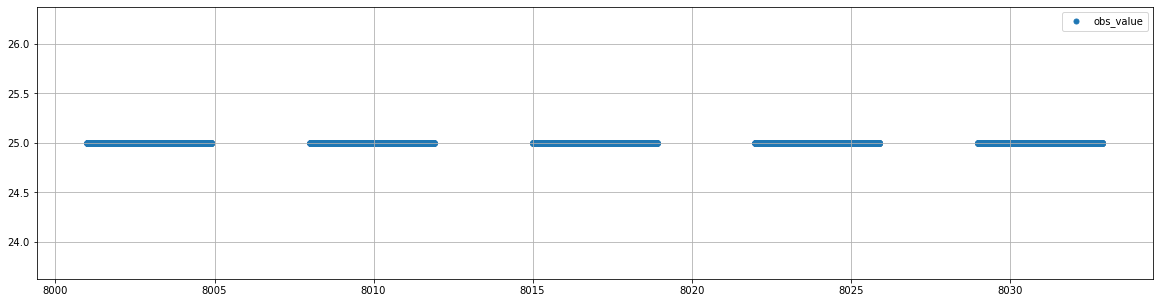

In [12]:
pRange=939
%matplotlib inline
fig = plt.figure(figsize=(20,5))
ax = plt.axes()

for dates in datelist:

    filenameObs=obsVerifFilePath+prefixObs+''+str(dates)+'.nc'
    print('loading ',filenameObs)
    obs=xr.open_dataset(filenameObs).load()
    vobs=obs.obs_value.where(obs.obs_provenance==pRange)
    lo=obs.obs_lon.where(obs.obs_provenance==pRange)
    la=obs.obs_lat.where(obs.obs_provenance==pRange)
    t=obs.obs_time.where(obs.obs_provenance==pRange)

    ax.plot(t, vobs, "C0", marker='.', markersize=10, linestyle='None',zorder=1)

ax.plot(t, vobs, "C0", marker='.', markersize=10, linestyle='None',label='obs_value',zorder=1)
ax.legend()
# ax.set_xlim([8010.4,8010.6])
ax.grid(True)


# Plot up mod file, which is output from first truth run
Change plots to NLmodel_value, which is the model value at obs_value points(x,y,z,t)

In [ ]:
### Load osse obs and mod file data

# for dates in datelist:

#     filenameObs=obsVerifFilePath+prefixObs+''+str(dates)+'.nc'
#     print('loading ',filenameObs)
#     obs=xr.open_dataset(filenameObs).load()




for day in datelist: 
    modFileName = '0'+str(day)+'.nc'
    modPath = modTruthFilePath+prefixMod+modFileName
    print('       opening '+modFileName)
    mod = xr.open_dataset(modPath)


    pRange=405
    print('obs_depth',mod.obs_depth.where(mod.obs_provenance==pRange, drop=True).values, mod.obs_depth.where(mod.obs_provenance==pRange, drop=True).values.mean())
    print('obs_Zgrid',mod.obs_Zgrid.where(mod.obs_provenance==pRange, drop=True).values, mod.obs_Zgrid.where(mod.obs_provenance==pRange, drop=True).values.mean())
    print('obs_value',mod.obs_value.where(mod.obs_provenance==pRange, drop=True).values, mod.obs_value.where(mod.obs_provenance==pRange, drop=True).values.mean())
    print('NLmodel_value',mod.NLmodel_value.where(mod.obs_provenance==pRange, drop=True).values, mod.obs_value.where(mod.obs_provenance==pRange, drop=True).values.mean())
    print('obs_type',mod.obs_type.where(mod.obs_provenance==pRange, drop=True).values, mod.obs_type.where(mod.obs_provenance==pRange, drop=True).values.mean())

    pRange=340
    print('obs_depth',mod.obs_depth.where(mod.obs_provenance==pRange, drop=True).values, mod.obs_depth.where(mod.obs_provenance==pRange, drop=True).values.mean())
    print('obs_Zgrid',mod.obs_Zgrid.where(mod.obs_provenance==pRange, drop=True).values, mod.obs_Zgrid.where(mod.obs_provenance==pRange, drop=True).values.mean())
    print('obs_value',mod.obs_value.where(mod.obs_provenance==pRange, drop=True).values, mod.obs_value.where(mod.obs_provenance==pRange, drop=True).values.mean())
    print('NLmodel_value',mod.NLmodel_value.where(mod.obs_provenance==pRange, drop=True).values, mod.obs_value.where(mod.obs_provenance==pRange, drop=True).values.mean())
    print('obs_type',mod.obs_type.where(mod.obs_provenance==pRange, drop=True).values, mod.obs_type.where(mod.obs_provenance==pRange, drop=True).values.mean())


    pRange=939
    print('obs_depth',mod.obs_depth.where(mod.obs_provenance==pRange, drop=True).values, mod.obs_depth.where(mod.obs_provenance==pRange, drop=True).values.mean())
    print('obs_Zgrid',mod.obs_Zgrid.where(mod.obs_provenance==pRange, drop=True).values, mod.obs_Zgrid.where(mod.obs_provenance==pRange, drop=True).values.mean())
    print('obs_value',mod.obs_value.where(mod.obs_provenance==pRange, drop=True).values, mod.obs_value.where(mod.obs_provenance==pRange, drop=True).values.mean())
    print('NLmodel_value',mod.NLmodel_value.where(mod.obs_provenance==pRange, drop=True).values, mod.obs_value.where(mod.obs_provenance==pRange, drop=True).values.mean())
    print('obs_type',mod.obs_type.where(mod.obs_provenance==pRange, drop=True).values, mod.obs_type.where(mod.obs_provenance==pRange, drop=True).values.mean())

       opening 08001.nc
obs_depth [] nan
obs_Zgrid [] nan
obs_value [] nan
NLmodel_value [] nan
obs_type [] nan
obs_depth [] nan
obs_Zgrid [] nan
obs_value [] nan
NLmodel_value [] nan
obs_type [] nan
obs_depth [  -4.16034254  -13.66340378  -23.37907118 ... -510.39969198 -636.03774177
 -760.88254615] -194.86721188076004
obs_Zgrid [26.9096622  22.29417541 18.89615312 ...  6.51158633  5.51739201
  4.69338983] 17.37614102036143
obs_value [25. 25. 25. ... 25. 25. 25.] 25.0
NLmodel_value [20.86125354 20.79569103 20.71129724 ...  9.43464091  7.80821638
  6.43254124] 25.0
obs_type [6. 6. 6. ... 6. 6. 6.] 6.0
       opening 08005.nc
obs_depth [] nan
obs_Zgrid [] nan
obs_value [] nan
NLmodel_value [] nan
obs_type [] nan
obs_depth [] nan
obs_Zgrid [] nan
obs_value [] nan
NLmodel_value [] nan
obs_type [] nan
obs_depth [  -4.16034254  -13.66340378  -23.37907118 ... -484.26744218 -618.10186863
 -757.62352712] -183.7212026778435
obs_Zgrid [26.9096622  22.29417541 18.89615312 ... 10.47996276  9.479103

<ipython-input-103-daf1fd5326d4>:20: RuntimeWarning: Mean of empty slice.
  print('obs_depth',mod.obs_depth.where(mod.obs_provenance==pRange, drop=True).values, mod.obs_depth.where(mod.obs_provenance==pRange, drop=True).values.mean())
/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-103-daf1fd5326d4>:21: RuntimeWarning: Mean of empty slice.
  print('obs_Zgrid',mod.obs_Zgrid.where(mod.obs_provenance==pRange, drop=True).values, mod.obs_Zgrid.where(mod.obs_provenance==pRange, drop=True).values.mean())
/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-103-daf1fd5326d4>:22: RuntimeWarning: Mean of empty slice.
  print('obs_value',mod.obs_value.where(mod.obs_provenance==pRange, drop=True).val

NLmodel_value [22.71321376 22.15808371 21.41357107 ...  9.95175368  7.88070677
  6.72074702] 25.0
obs_type [6. 6. 6. ... 6. 6. 6.] 6.0
       opening 08017.nc
obs_depth [] nan
obs_Zgrid [] nan
obs_value [] nan
NLmodel_value [] nan
obs_type [] nan
obs_depth [] nan
obs_Zgrid [] nan
obs_value [] nan
NLmodel_value [] nan
obs_type [] nan
obs_depth [  -2.784241    -11.96388304  -21.47761524 ... -510.39969198 -636.03774177
 -760.88254615] -198.41632927205634
obs_Zgrid [29.21406106 27.24254553 25.72112161 ...  6.51158633  5.51739201
  4.69338983] 17.5550147081052
obs_value [25. 25. 25. ... 25. 25. 25.] 25.0
NLmodel_value [21.10750388 21.10580933 21.10451917 ...  9.78003388  8.01999167
  6.64200656] 25.0
obs_type [6. 6. 6. ... 6. 6. 6.] 6.0
       opening 08021.nc
obs_depth [] nan
obs_Zgrid [] nan
obs_value [] nan
NLmodel_value [] nan
obs_type [] nan
obs_depth [] nan
obs_Zgrid [] nan
obs_value [] nan
NLmodel_value [] nan
obs_type [] nan
obs_depth [  -4.16034254  -13.66340378  -23.37907118 ... -

<ipython-input-103-daf1fd5326d4>:20: RuntimeWarning: Mean of empty slice.
  print('obs_depth',mod.obs_depth.where(mod.obs_provenance==pRange, drop=True).values, mod.obs_depth.where(mod.obs_provenance==pRange, drop=True).values.mean())
/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-103-daf1fd5326d4>:21: RuntimeWarning: Mean of empty slice.
  print('obs_Zgrid',mod.obs_Zgrid.where(mod.obs_provenance==pRange, drop=True).values, mod.obs_Zgrid.where(mod.obs_provenance==pRange, drop=True).values.mean())
/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-103-daf1fd5326d4>:22: RuntimeWarning: Mean of empty slice.
  print('obs_value',mod.obs_value.where(mod.obs_provenance==pRange, drop=True).val

       opening 08001.nc
8001
<xarray.DataArray 'NLmodel_value' ()>
array(17.27217167)
8002
<xarray.DataArray 'NLmodel_value' ()>
array(18.36322931)
8003
<xarray.DataArray 'NLmodel_value' ()>
array(16.91976781)
8004
<xarray.DataArray 'NLmodel_value' ()>
array(16.14638394)
8005
<xarray.DataArray 'NLmodel_value' ()>
array(nan)
       opening 08005.nc
8005
<xarray.DataArray 'NLmodel_value' ()>
array(nan)
8006
<xarray.DataArray 'NLmodel_value' ()>
array(nan)
8007
<xarray.DataArray 'NLmodel_value' ()>
array(nan)
8008
<xarray.DataArray 'NLmodel_value' ()>
array(18.11492338)
8009
<xarray.DataArray 'NLmodel_value' ()>
array(nan)
       opening 08009.nc
8009
<xarray.DataArray 'NLmodel_value' ()>
array(18.52059094)
8010
<xarray.DataArray 'NLmodel_value' ()>
array(16.84565368)
8011
<xarray.DataArray 'NLmodel_value' ()>
array(16.20644427)
8012
<xarray.DataArray 'NLmodel_value' ()>
array(nan)
8013
<xarray.DataArray 'NLmodel_value' ()>
array(nan)
       opening 08013.nc
8013
<xarray.DataArray 'NLmode

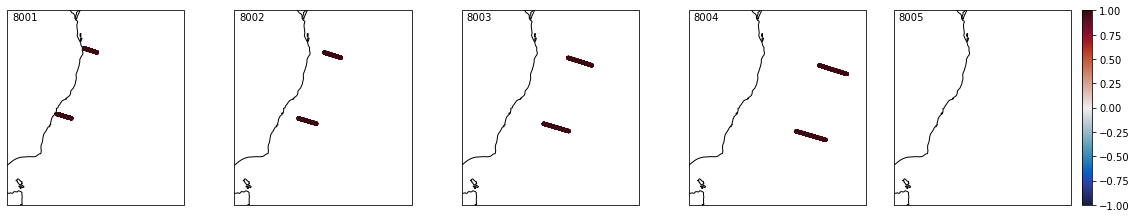

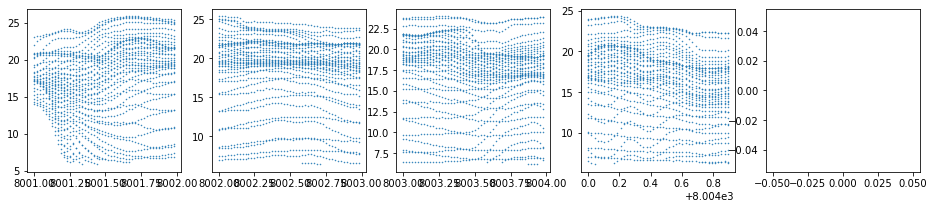

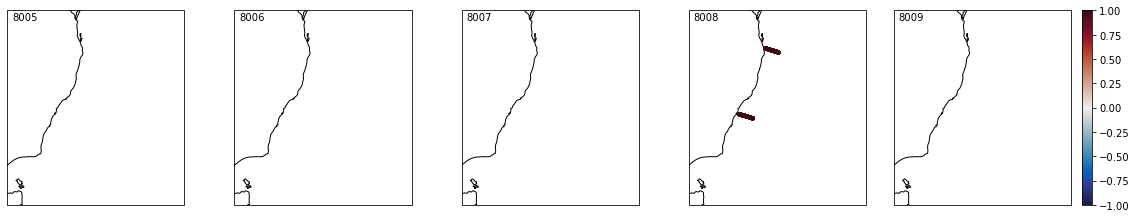

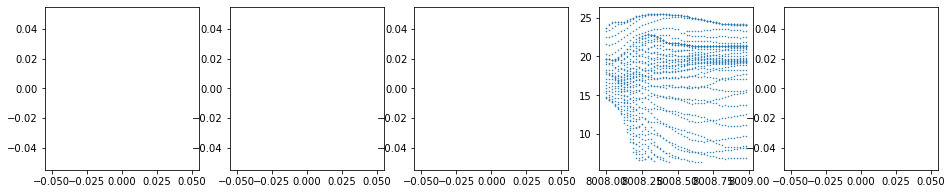

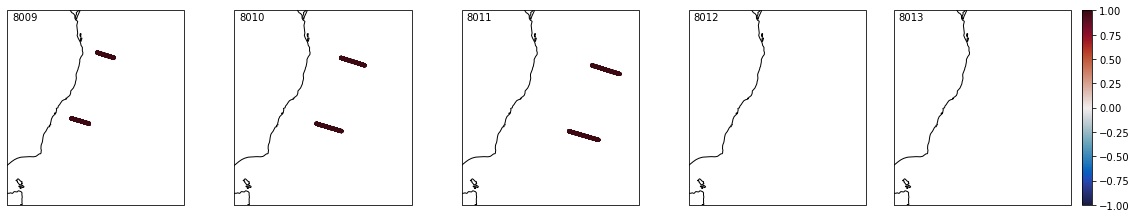

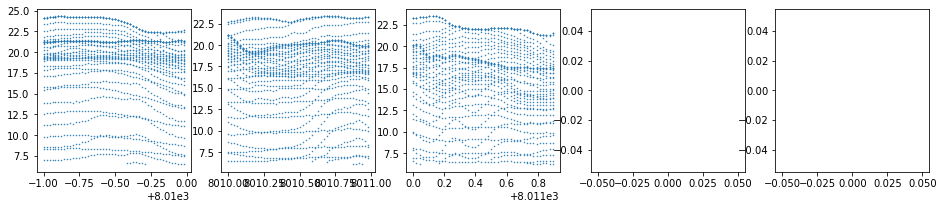

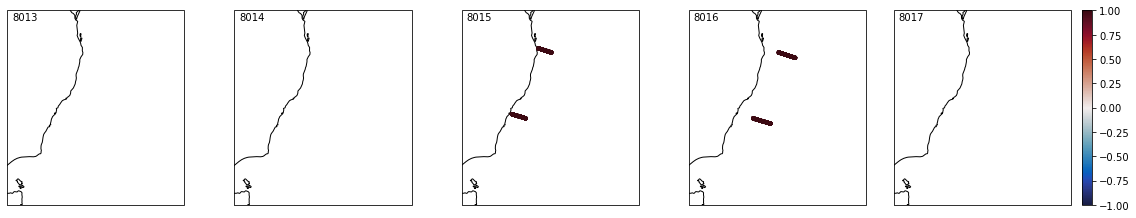

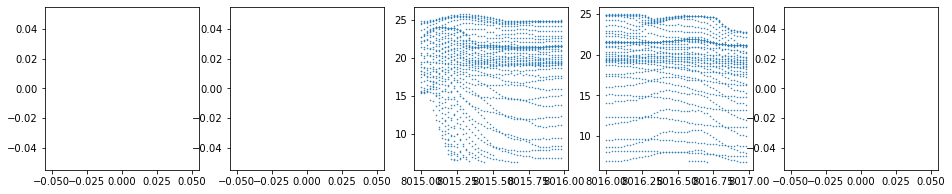

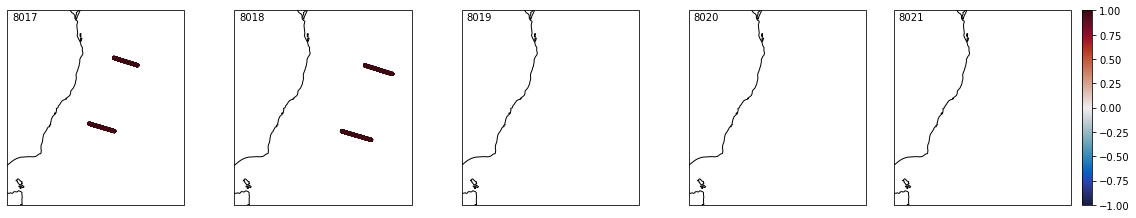

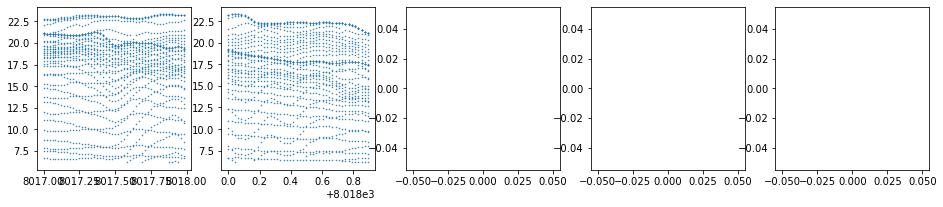

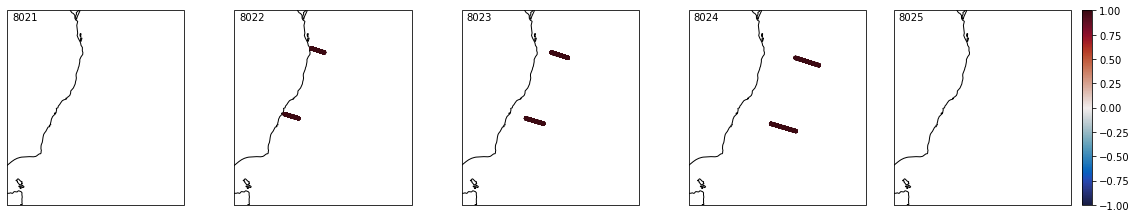

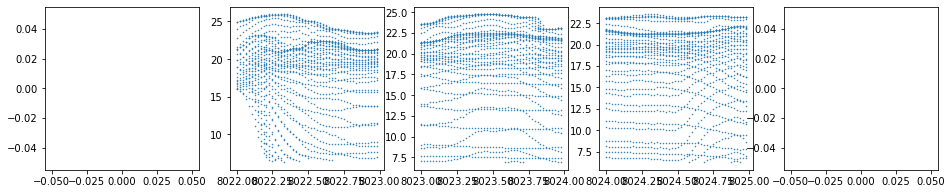

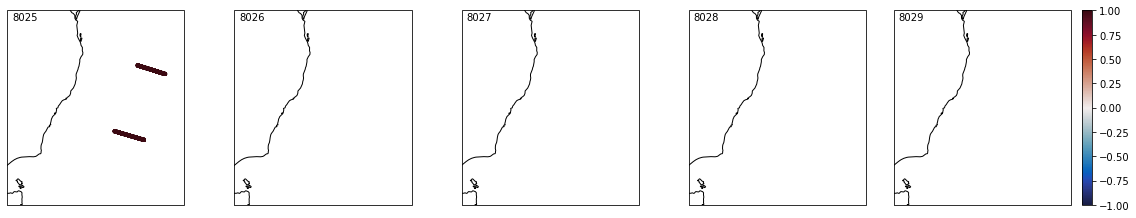

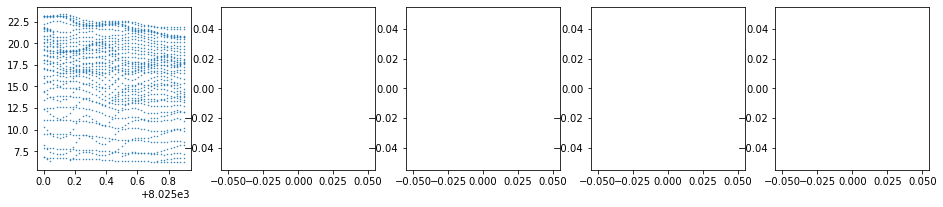

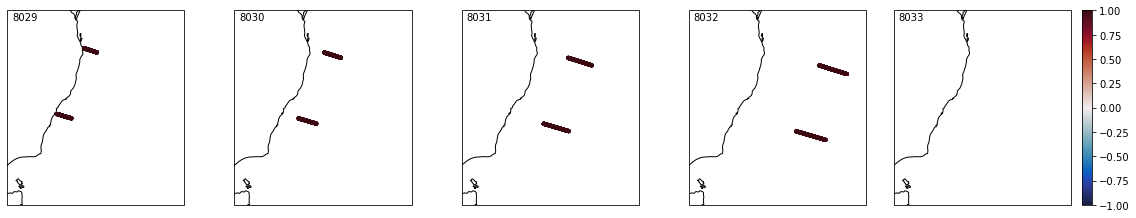

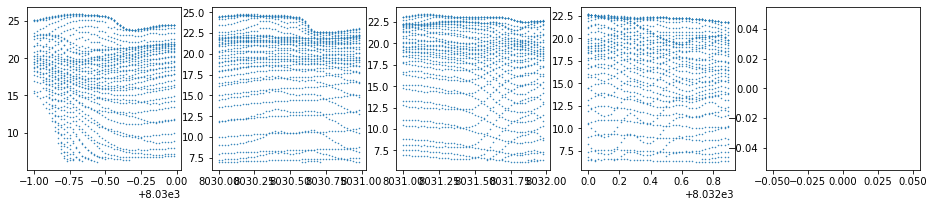

In [32]:
pRange=939


# datelist = np.array([8005, 8009])

for day in datelist: 
    modFileName = '0'+str(day)+'.nc'
    modPath = modTruthFilePath+prefixMod+modFileName
    print('       opening '+modFileName)
    mod = xr.open_dataset(modPath)



    tRange=np.arange(day,day+assimPeriod,1)
    fig, axes = plt.subplots(ncols=assimPeriod, figsize=(16, 3), subplot_kw={'projection': ccrs.PlateCarree()})
    for ax, tRangeStart in zip(axes, tRange):
        v=mod.NLmodel_value.where(mod.obs_provenance==pRange).where((mod.obs_time>=tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==pRange).where((mod.obs_time>=tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==pRange).where((mod.obs_time>=tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==pRange).where((mod.obs_time>=tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='none')
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance, vmin=-1, vmax=1, zorder=10)
        ax.text(.1,.95,str(tRangeStart),horizontalalignment='center',transform=ax.transAxes)
        sc.set_clim([-1,1])
    plt.tight_layout()
    fig.colorbar(sc)

    fig, axes = plt.subplots(ncols=assimPeriod, figsize=(16, 3))
    for ax, tRangeStart in zip(axes, tRange):
        print(tRangeStart)
        v=mod.NLmodel_value.where(mod.obs_provenance==pRange).where((mod.obs_time>=tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==pRange).where((mod.obs_time>=tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==pRange).where((mod.obs_time>=tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==pRange).where((mod.obs_time>=tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
        ax.plot(t,v, marker='.', markersize=1, linestyle='None')
        print(v.mean())



In [95]:

%matplotlib widget

datelist=np.array([8029])

for day in datelist: 
    modFileName = '0'+str(day)+'.nc'
    modPath = modTruthFilePath+prefixMod+modFileName
    print('       opening '+modFileName)
    mod = xr.open_dataset(modPath)
    
    pRange=939
    tRange=np.arange(day,day+assimPeriod,1)
    for tRangeStart in tRange:
        fig, axes = plt.subplots(1, figsize=(8, 8), subplot_kw={'projection': '3d'})
        ax = axes
        v=mod.NLmodel_value.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
        d=mod.obs_depth.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
        ax.set_xlim3d([147,162.5])
        ax.set_ylim3d([-42,-25])
        # ax.set_zlim3d([-1200,0])

        # ax.set_extent([147, 162.5, -42, -25,-1200,0])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='none')

        ba = ax.contour3D(grid.lon_rho.values,grid.lat_rho.values,-grid.h.values,50,cmap='viridis',zorder=1)

        sc = ax.scatter3D(lo,la,d,c=v,marker='.', cmap = cmaps.cmocean_balance,zorder=10)
        # ax.text(.3,.95,str(tRangeStart),horizontalalignment='center',transform=ax.transAxes)
        sc.set_clim([15,30])
    # plt.tight_layout()
    # fig.colorbar(sc)



       opening 08029.nc


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Now look at the finalised obs file.


In [ ]:


for day in datelist: 
    obsFileName = ''+str(day)+'.nc'
    obsPath = obsFinalFilePath+prefixObs+obsFileName
    print('       opening '+obsFileName)
    obs = xr.open_dataset(obsPath)


    pRange=405
    print('obs_depth',obs.obs_depth.where(obs.obs_provenance==pRange, drop=True).values, obs.obs_depth.where(obs.obs_provenance==pRange, drop=True).values.mean())
    print('obs_Zgrid',obs.obs_Zgrid.where(obs.obs_provenance==pRange, drop=True).values, obs.obs_Zgrid.where(obs.obs_provenance==pRange, drop=True).values.mean())
    print('obs_value',obs.obs_value.where(obs.obs_provenance==pRange, drop=True).values, obs.obs_value.where(obs.obs_provenance==pRange, drop=True).values.mean())
    print('obs_type',obs.obs_type.where(obs.obs_provenance==pRange, drop=True).values, obs.obs_type.where(obs.obs_provenance==pRange, drop=True).values.mean())

    pRange=340
    print('obs_depth',obs.obs_depth.where(obs.obs_provenance==pRange, drop=True).values, obs.obs_depth.where(obs.obs_provenance==pRange, drop=True).values.mean())
    print('obs_Zgrid',obs.obs_Zgrid.where(obs.obs_provenance==pRange, drop=True).values, obs.obs_Zgrid.where(obs.obs_provenance==pRange, drop=True).values.mean())
    print('obs_value',obs.obs_value.where(obs.obs_provenance==pRange, drop=True).values, obs.obs_value.where(obs.obs_provenance==pRange, drop=True).values.mean())
    print('obs_type',obs.obs_type.where(obs.obs_provenance==pRange, drop=True).values, obs.obs_type.where(obs.obs_provenance==pRange, drop=True).values.mean())
    
    pRange=939
    print('obs_depth',obs.obs_depth.where(obs.obs_provenance==pRange, drop=True).values, obs.obs_depth.where(obs.obs_provenance==pRange, drop=True).values.mean())
    print('obs_Zgrid',obs.obs_Zgrid.where(obs.obs_provenance==pRange, drop=True).values, obs.obs_Zgrid.where(obs.obs_provenance==pRange, drop=True).values.mean())
    print('obs_value',obs.obs_value.where(obs.obs_provenance==pRange, drop=True).values, obs.obs_value.where(obs.obs_provenance==pRange, drop=True).values.mean())
    print('obs_type',obs.obs_type.where(obs.obs_provenance==pRange, drop=True).values, obs.obs_type.where(obs.obs_provenance==pRange, drop=True).values.mean())

       opening 8001.nc
obs_depth [30. 30. 30. ... 30. 30. 30.] 30.0
obs_Zgrid [0. 0. 0. ... 0. 0. 0.] 0.0
obs_value [0.17380531 0.05273031 0.11926377 ... 0.38030142 0.37964471 0.29341458] 0.34417825300488425
obs_type [1. 1. 1. ... 1. 1. 1.] 1.0
obs_depth [30. 30. 30. ... 30. 30. 30.] 30.0
obs_Zgrid [0. 0. 0. ... 0. 0. 0.] 0.0
obs_value [20.5259468  20.004005   20.85017197 ... 22.51450818 22.03371527
 21.62594997] 21.232102557604644
obs_type [6. 6. 6. ... 6. 6. 6.] 6.0
obs_depth [26.9096622  22.29417541 18.89615312 ...  6.51158633  5.51739201
  4.69338983] 17.37614102036143
obs_Zgrid [26.9096622  22.29417541 18.89615312 ...  6.51158633  5.51739201
  4.69338983] 17.37614102036143
obs_value [20.91502025 20.97907953 20.48541256 ...  9.51467537  7.76360376
  6.43483699] 17.189946594922812
obs_type [6. 6. 6. ... 6. 6. 6.] 6.0
       opening 8005.nc
obs_depth [30. 30. 30. ... 30. 30. 30.] 30.0
obs_Zgrid [0. 0. 0. ... 0. 0. 0.] 0.0
obs_value [0.34955437 0.41735853 0.4301529  ... 0.13593812 0.2

loading  /Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_final_SSH_SST_XBT/eac_obs_8005.nc
-119.51999999946565  mins
-120.95999999975902 mins


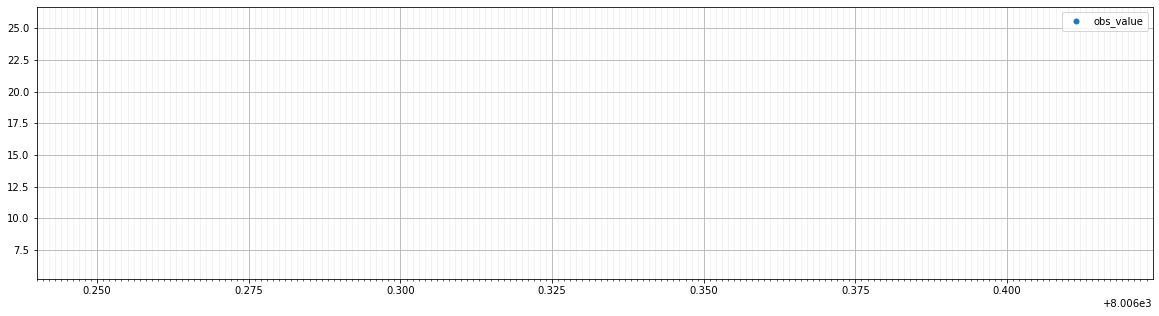

In [ ]:
pRange=939

fig = plt.figure(figsize=(20,5))
ax = plt.axes()

for dates in np.array([8005]):

    filenameObs=obsFinalFilePath+prefixObs+''+str(dates)+'.nc'
    print('loading ',filenameObs)
    obs=xr.open_dataset(filenameObs).load()
    vobs=obs.obs_value.where(obs.obs_provenance==pRange)
    lo=obs.obs_lon.where(obs.obs_provenance==pRange)
    la=obs.obs_lat.where(obs.obs_provenance==pRange)
    t=obs.obs_time.where(obs.obs_provenance==pRange)

    ax.plot(t, vobs, "C0", marker='.', markersize=10, linestyle='None',zorder=1)

ax.plot(t, vobs, "C0", marker='.', markersize=10, linestyle='None',label='obs_value',zorder=1)
ax.legend()
ax.grid(True)
minor_ticks = np.arange(8005, 8009, .001)
ax.set_xticks(minor_ticks, minor=True), ax.grid(which='minor', alpha=0.2)
ax.set_xlim([8006.24,8006.424])

print(str((8006.247 - 8006.330)*(24*60)),' mins')
print(str((8006.326 - 8006.410)*(24*60)),'mins')


In [ ]:
# dates=np.array(8005)
# pRange=939

# filenameObs=obsFinalFilePath+prefixObs+''+str(dates)+'.nc'
# print('loading ',filenameObs)
# obs=xr.open_dataset(filenameObs).load()
# v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>=8005) & (obs.obs_time<8006+1), drop=True)
# np.unique(obs.obs_provenance)
filenameObs
# np.unique(obs.obs_provenance)

'/Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_final_SSH_SST_XBT/eac_obs_8005.nc'

       opening 8005.nc
       opening 8009.nc


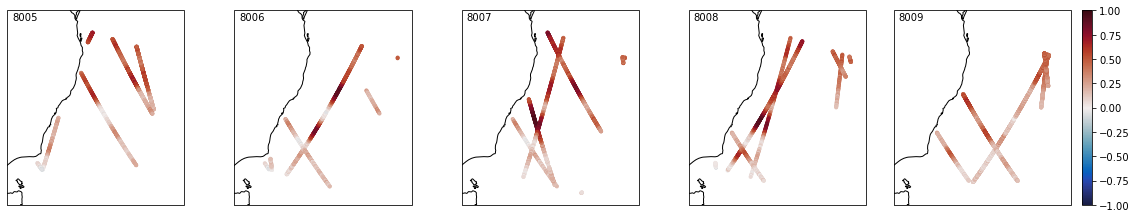

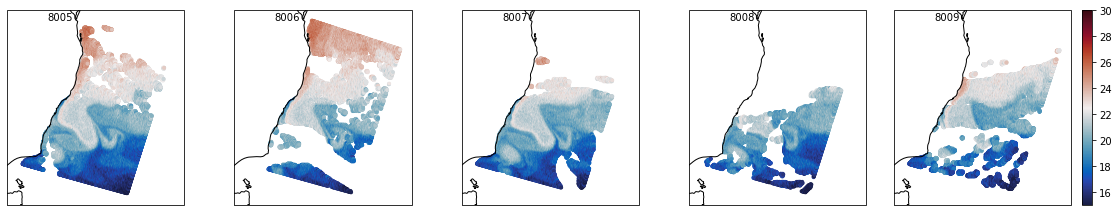

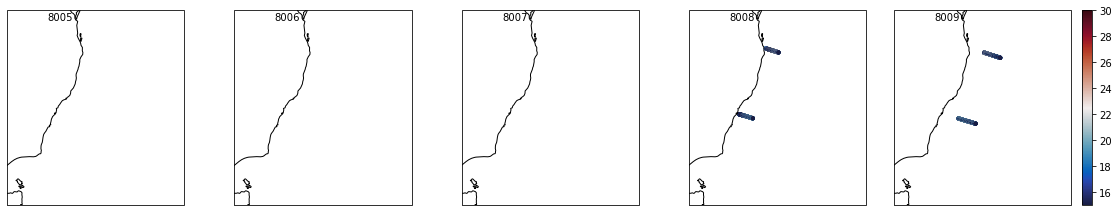

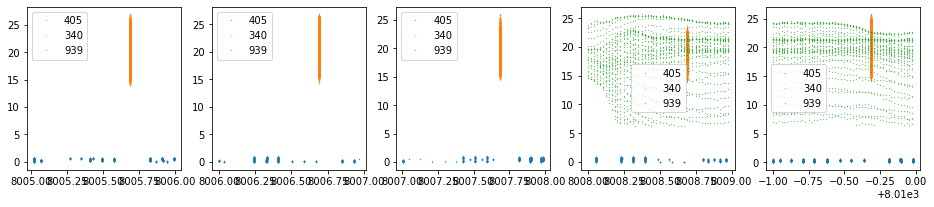

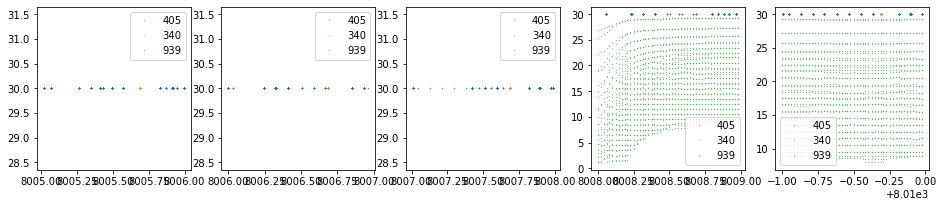

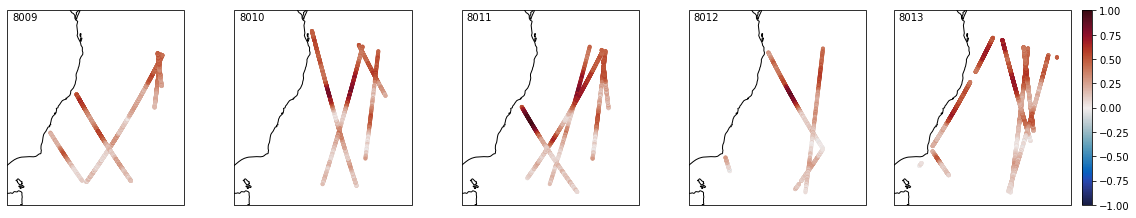

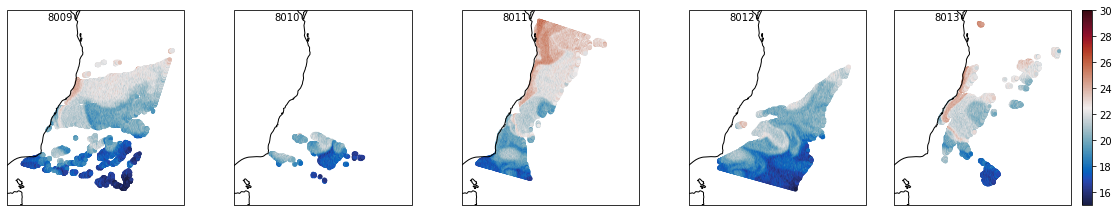

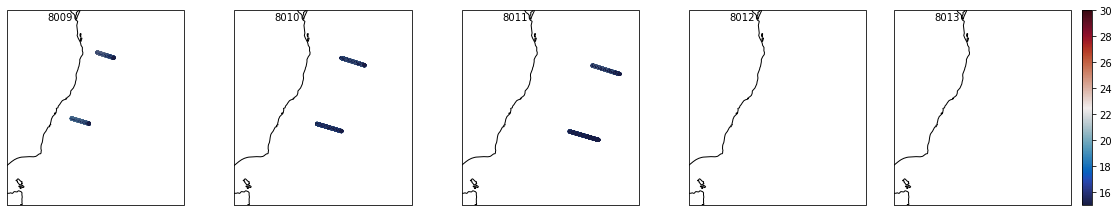

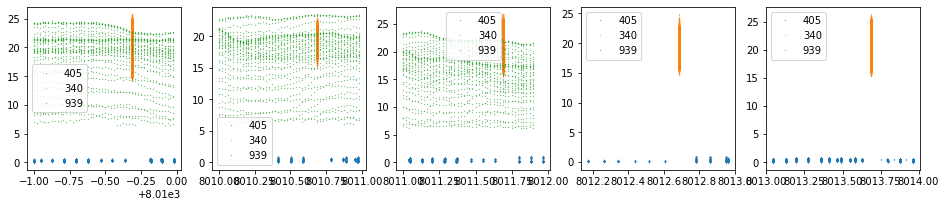

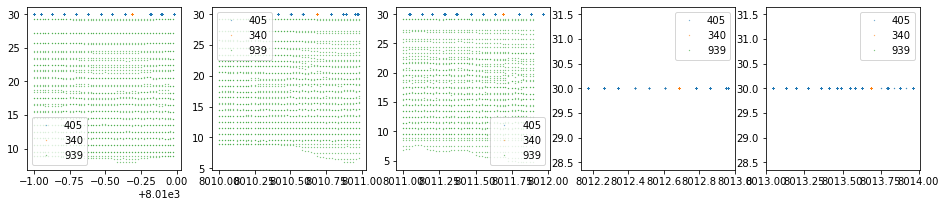

In [ ]:
datelist=np.array([8005,8009])
for day in datelist: 
    obsFileName = ''+str(day)+'.nc'
    obsPath = obsFinalFilePath+prefixObs+obsFileName
    print('       opening '+obsFileName)
    obs = xr.open_dataset(obsPath)

    pRange=405
    tRange=np.arange(day,day+assimPeriod,1)
    fig, axes = plt.subplots(ncols=assimPeriod, figsize=(16, 3), subplot_kw={'projection': ccrs.PlateCarree()})
    for ax, tRangeStart in zip(axes, tRange):
        v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>=tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>=tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>=tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>=tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='none')
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance, vmin=-1, vmax=1, zorder=10)
        ax.text(.1,.95,str(tRangeStart),horizontalalignment='center',transform=ax.transAxes)
        sc.set_clim([-1,1])
    plt.tight_layout()
    fig.colorbar(sc)

    pRange=340
    tRange=np.arange(day,day+assimPeriod,1)
    fig, axes = plt.subplots(ncols=assimPeriod, figsize=(16, 3), subplot_kw={'projection': ccrs.PlateCarree()})
    for ax, tRangeStart in zip(axes, tRange):
        v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='none')
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance)
        ax.text(.3,.95,str(tRangeStart),horizontalalignment='center',transform=ax.transAxes)
        sc.set_clim([15,30])
    plt.tight_layout()
    fig.colorbar(sc)

    pRange=939
    tRange=np.arange(day,day+assimPeriod,1)
    fig, axes = plt.subplots(ncols=assimPeriod, figsize=(16, 3), subplot_kw={'projection': ccrs.PlateCarree()})
    for ax, tRangeStart in zip(axes, tRange):
        v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='none')
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance)
        ax.text(.3,.95,str(tRangeStart),horizontalalignment='center',transform=ax.transAxes)
        sc.set_clim([15,30])
    plt.tight_layout()
    fig.colorbar(sc)

    fig, axes = plt.subplots(ncols=assimPeriod, figsize=(16, 3))
    for ax, tRangeStart in zip(axes, tRange):
        pRange=405
        v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>=tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>=tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>=tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>=tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        ax.plot(t,v,marker='.',markersize=0.5,linestyle='none',label=str(pRange),color='C0')
        pRange=340
        v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>=tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>=tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>=tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>=tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        ax.plot(t,v,marker='.',markersize=0.5,linestyle='none',label=str(pRange),color='C1')
        pRange=939
        v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>=tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>=tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>=tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>=tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        ax.plot(t,v,marker='.',markersize=0.5,linestyle='none',label=str(pRange),color='C2')
        ax.legend()

    fig, axes = plt.subplots(ncols=assimPeriod, figsize=(16, 3))
    for ax, tRangeStart in zip(axes, tRange):
        pRange=405
        d=obs.obs_depth.where(obs.obs_provenance==pRange).where((obs.obs_time>=tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>=tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>=tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>=tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        ax.plot(t,d,marker='.',markersize=0.5,linestyle='none',label=str(pRange),color='C0')
        pRange=340
        d=obs.obs_depth.where(obs.obs_provenance==pRange).where((obs.obs_time>=tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>=tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>=tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>=tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        ax.plot(t,d,marker='.',markersize=0.5,linestyle='none',label=str(pRange),color='C1')
        pRange=939
        d=obs.obs_depth.where(obs.obs_provenance==pRange).where((obs.obs_time>=tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>=tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>=tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>=tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        ax.plot(t,d,marker='.',markersize=0.5,linestyle='none',label=str(pRange),color='C2')
        ax.legend()